In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Solar Power in Burlington VT

This notebook will examine different weather features and solar panel output from near Burlington, VT from 2017 to 2023. 

## Reading in the data with a little cleaning 

The data are split into four *.csv* files based on the information stored:

1) **solar.csv** records the power generated by the solar panels in 15 minute intervals
   - *date*: the date (`m/d/yyyy`) and time (`h:mm`) of the measurement
   - *value*: The output of the solar panels in watts since the previous recording


In [3]:
solar = pd.read_csv('data/solar.csv')

# Converting date to a date time object
solar['date'] = pd.to_datetime(solar['date'], format = '%m/%d/%Y %H:%M')

print(solar.dtypes)
solar

date     datetime64[ns]
value           float64
dtype: object


,date,value
0,2017-07-27 00:00:00,NaN
1,2017-07-27 00:15:00,NaN
2,2017-07-27 00:30:00,NaN
3,2017-07-27 00:45:00,NaN
4,2017-07-27 01:00:00,NaN
...,...,...
210811,2023-07-31 22:45:00,NaN
210812,2023-07-31 23:00:00,NaN
210813,2023-07-31 23:15:00,NaN
210814,2023-07-31 23:30:00,NaN


2) **weather.csv** records several features about the daily weather from an outside weather station. Some of the important features are:
   - *date*: the date of the day (no time)
   - *temperatureMax* and *temperatureMin*: The daily high and daily low temperature, respectively, in degrees F.
   - *rainTotal*: The total rainfall of that day.
   - *barometerMax* and *barometerMin*: The maximum and minimum daily pressure, respectively.
   - *cloudMax* and *cloudMin*: A measurement of how cloudy the day is.
   - *humidityMax* and *humidityMin*: The max and min humidity for the day.

In [5]:
weather = pd.read_csv('data/weather.csv')
weather['date'] = pd.to_datetime(weather['date'])
print(weather.dtypes)
weather

date              datetime64[ns]
temperatureMax           float64
temperatureMin           float64
rainTotal                float64
rainPercent              float64
barometerMax             float64
barometerMin             float64
cloudMax                 float64
cloudMin                 float64
humidityMax              float64
humidityMin              float64
dtype: object


,date,temperatureMax,temperatureMin,rainTotal,rainPercent,barometerMax,barometerMin,cloudMax,cloudMin,humidityMax,humidityMin
0,2017-01-01,34.076,29.120,0.000,0.00,30.165,29.499,NaN,NaN,87.0,64.655
1,2017-01-02,40.764,14.106,0.026,0.35,30.314,30.165,NaN,NaN,85.0,79.000
2,2017-01-03,38.420,18.680,0.026,0.35,30.300,29.512,NaN,NaN,86.0,72.000
3,2017-01-04,38.219,31.376,0.259,3.47,29.512,29.118,NaN,NaN,86.0,74.000
4,2017-01-05,31.280,20.480,0.000,0.00,29.547,29.242,NaN,NaN,74.0,52.000
...,...,...,...,...,...,...,...,...,...,...,...
2393,2023-08-05,79.844,54.140,0.000,0.00,30.121,29.942,4979.086,1737.317,85.0,53.000
2394,2023-08-06,83.228,51.868,0.000,0.00,30.117,30.041,5653.658,1873.032,83.0,48.207
2395,2023-08-07,68.540,53.600,0.000,0.00,30.089,29.816,3109.470,2032.068,81.0,69.000
2396,2023-08-08,74.624,64.760,1.139,10.42,29.822,29.608,2516.345,1866.708,84.0,76.000


---

3) **sun.csv** has daily measurements about the sun:
   - *date*: the date (no hour or minutes)
   - *sunrise* and *sunset*: The hour minute second when the sun rose and set
   - *elevation* and *azimuth*: Both measure the [sun's position in the sky](https://en.wikipedia.org/wiki/Solar_azimuth_angle). Since it is only recorded daily, they are the maximum values.

We'll create a column for lenth of time (in hours) that the sun is in the sky called *day_time* 

In [7]:
sun = pd.read_csv('data/sun.csv')
print(sun.dtypes)
sun

date          object
sunrise       object
sunset        object
elevation    float64
azimuth      float64
dtype: object


,date,sunrise,sunset,elevation,azimuth
0,2017-01-01,07:28:34,16:22:27,22.506600,181.117426
1,2017-01-02,07:28:35,16:23:23,22.599328,181.003083
2,2017-01-03,07:28:32,16:24:20,22.699437,180.890026
3,2017-01-04,07:28:28,16:25:19,22.806883,180.778345
4,2017-01-05,07:28:20,16:26:20,22.921620,180.668129
...,...,...,...,...,...
2551,2023-12-27,07:27:44,16:17:48,22.116926,181.792750
2552,2023-12-28,07:27:59,16:18:32,22.166938,181.672817
2553,2023-12-29,07:28:11,16:19:18,22.224517,181.553644
2554,2023-12-30,07:28:21,16:20:06,22.289637,181.435327


In [8]:
# Converting the date column to actual date dtype
sun['date'] = pd.to_datetime(sun.date)

# Converting sunrise and sunset to time dtypes
sun['sunrise'] = pd.to_datetime(sun['sunrise'], format = '%H:%M:%S').dt.time
sun['sunset']  = pd.to_datetime(sun['sunset'],  format = '%H:%M:%S').dt.time

# Creating day_time in hours
sun['day_time'] = pd.to_datetime(sun['sunset'], format = '%H:%M:%S') - pd.to_datetime(sun['sunrise'],  format = '%H:%M:%S')
sun['day_time'] = sun['day_time'].dt.total_seconds()/3600

print(sun.dtypes)
sun

date         datetime64[ns]
sunrise              object
sunset               object
elevation           float64
azimuth             float64
day_time            float64
dtype: object


,date,sunrise,sunset,elevation,azimuth,day_time
0,2017-01-01,07:28:34,16:22:27,22.506600,181.117426,8.898056
1,2017-01-02,07:28:35,16:23:23,22.599328,181.003083,8.913333
2,2017-01-03,07:28:32,16:24:20,22.699437,180.890026,8.930000
3,2017-01-04,07:28:28,16:25:19,22.806883,180.778345,8.947500
4,2017-01-05,07:28:20,16:26:20,22.921620,180.668129,8.966667
...,...,...,...,...,...,...
2551,2023-12-27,07:27:44,16:17:48,22.116926,181.792750,8.834444
2552,2023-12-28,07:27:59,16:18:32,22.166938,181.672817,8.842500
2553,2023-12-29,07:28:11,16:19:18,22.224517,181.553644,8.851944
2554,2023-12-30,07:28:21,16:20:06,22.289637,181.435327,8.862500


---

4) **precipitation.csv** has information about the rain and/or snow about each day, along with the amount of snow that has not melted
   - *date*: The date in m/d/yyyy
   - *precip*: The amount of precipitation, either rain or snow after it has melted, in inches
   - *snowfall*: The amount of snow (unmelted), in inches
   - *snow_pack*: Amount of snow of the ground (nearest half inch)

In [10]:
precipitation = pd.read_csv('data/precipitation.csv')
precipitation.columns = ['date', 'precip', 'snowfall', 'snow_pack']
print(precipitation.dtypes)
precipitation

date         object
precip       object
snowfall     object
snow_pack    object
dtype: object


,date,precip,snowfall,snow_pack
0,1/1/2017,0.01,0.2,4
1,1/2/2017,0,0,4
2,1/3/2017,T,T,3
3,1/4/2017,0.2,0.5,3
4,1/5/2017,0.02,0.2,2.5
...,...,...,...,...
2401,7/30/2023,0.43,0,0
2402,7/31/2023,0,0,0
2403,8/1/2023,0.02,0,0
2404,8/2/2023,0,0,0


For the columns **precipitation.csv**, if rain or snow occurred but below the detection limit, it is recorded at 'T'. If there was no rain or snow, then the column is denoted as 0. 

To account for the precip below detection limit, we'll add a *cloudy* column if there was any rain (`precip != '0'`), then convert the 'T' to 0.

Similarly, we'll add `snow_ground` which is yes if `snow_pack != 0` and no if `snow_pack = 0`

In [12]:
# Converting date to a datetime object
precipitation['date'] = pd.to_datetime(precipitation['date'])

# Creating a cloudy column for when precip =/= 0 and snow_ground when snow_pack =/= 0
precipitation['cloudy'] = np.where(precipitation['precip'] != '0', 'yes', 'no')

# Converting precip, snowfall, and snow_pack to floats by replacing T and -- with 0
precipitation['precip'] = np.where((precipitation['precip'] != 'T') & (precipitation['precip'] != '--'), # Condition
                                   precipitation['precip'],                                              # if True
                                   '0').astype(float)                                                    # if False and convert to float 


precipitation['snowfall'] = np.where((precipitation['snowfall'] != 'T') & (precipitation['snowfall'] != '--'), 
                                     precipitation['snowfall'], 
                                     '0').astype(float)


precipitation['snow_pack'] = np.where((precipitation['snow_pack'] != 'T') & (precipitation['snow_pack'] != '--'), 
                                     precipitation['snow_pack'], 
                                     '0').astype(float)

# Creating snow_ground if snow_pack > 0 -> yes, otherwise no
precipitation['snow_ground'] = np.where(precipitation['snow_pack'] > 0, 'yes', 'no')

print(precipitation.dtypes)
precipitation

date           datetime64[ns]
precip                float64
snowfall              float64
snow_pack             float64
cloudy                 object
snow_ground            object
dtype: object


,date,precip,snowfall,snow_pack,cloudy,snow_ground
0,2017-01-01,0.01,0.2,4.0,yes,yes
1,2017-01-02,0.00,0.0,4.0,no,yes
2,2017-01-03,0.00,0.0,3.0,yes,yes
3,2017-01-04,0.20,0.5,3.0,yes,yes
4,2017-01-05,0.02,0.2,2.5,yes,yes
...,...,...,...,...,...,...
2401,2023-07-30,0.43,0.0,0.0,yes,no
2402,2023-07-31,0.00,0.0,0.0,no,no
2403,2023-08-01,0.02,0.0,0.0,yes,no
2404,2023-08-02,0.00,0.0,0.0,no,no


## Combining data sets by date

The four different data sets (`solar`, `sun`, `weather`, `precipitation`) eventually need to be joined together. To merge the data sets properly, the rows need to be the same grainularity (case). Each row of `solar` is a 15 minute interval, while each other dataframe is on a daily basis.


In [14]:
solar

,date,value
0,2017-07-27 00:00:00,NaN
1,2017-07-27 00:15:00,NaN
2,2017-07-27 00:30:00,NaN
3,2017-07-27 00:45:00,NaN
4,2017-07-27 01:00:00,NaN
...,...,...
210811,2023-07-31 22:45:00,NaN
210812,2023-07-31 23:00:00,NaN
210813,2023-07-31 23:15:00,NaN
210814,2023-07-31 23:30:00,NaN


Additionally, if the panels didn't generate power (like at night), they aren't recorded as 0s but as `NaN`, so we'll change `NaN` to 0.

In [16]:
# Creating a daily solar data set
daily_solar = (
    solar
    # Converting NaN to 0
    .fillna(0)
    # Extracting the date (not time) from date
    .assign(date = lambda X: X['date'].dt.date)
    # Adding the value for each day
    .groupby('date').sum()
    # Adding date back as a column
    .reset_index()
    # Changing date back to a date type column
    .assign(date = lambda X: pd.to_datetime(X['date']))
)

daily_solar.dtypes

date     datetime64[ns]
value           float64
dtype: object

Now that the rows of each data set records daily metrics, we can merge the data sets!

In [18]:
complete_solar = (
    daily_solar
    # Adding weather to daily_solar
    .merge(
        right = weather,
        on = 'date',
        how = 'inner'
    )
    # adding sun 
    .merge(
        right = sun,
        on = 'date',
        how = 'inner'
    )
    # Adding precipitation 
    .merge(
        right = precipitation,
        on = 'date',
        how = 'inner'
    )
)

complete_solar.dtypes

date              datetime64[ns]
value                    float64
temperatureMax           float64
temperatureMin           float64
rainTotal                float64
rainPercent              float64
barometerMax             float64
barometerMin             float64
cloudMax                 float64
cloudMin                 float64
humidityMax              float64
humidityMin              float64
sunrise                   object
sunset                    object
elevation                float64
azimuth                  float64
day_time                 float64
precip                   float64
snowfall                 float64
snow_pack                float64
cloudy                    object
snow_ground               object
dtype: object

Some other touch ups:

- Rename `value` to `power`
- convert `power` to kW instead of Watts
- Add columns for `month`, `month_label`, `day_of_year`, and `year`

In [20]:
# Full month order
month_order = ['January', 'February',     'March', 
                 'April',      'May',      'June', 
                  'July',   'August', 'September', 
               'October', 'November',  'December']

# Renaming value to power
complete_solar.rename(columns = {'value': 'power'}, inplace = True)

# Converting to kW
complete_solar['power'] = complete_solar['power']/1000

# Adding day of year, month, and year columns
complete_solar['day_year']    = complete_solar['date'].dt.dayofyear
complete_solar['month']       = complete_solar['date'].dt.month
complete_solar['month_label'] = pd.Categorical(complete_solar['date'].dt.strftime('%B'), categories = month_order, ordered = True)
complete_solar['year']        = complete_solar['date'].dt.year

complete_solar

,date,power,temperatureMax,temperatureMin,rainTotal,rainPercent,barometerMax,barometerMin,cloudMax,cloudMin,...,day_time,precip,snowfall,snow_pack,cloudy,snow_ground,day_year,month,month_label,year
0,2017-07-27,9.089,78.868,62.240,0.414,2.43,30.157,29.929,NaN,NaN,...,14.830556,0.06,0.0,0.0,yes,no,208,7,July,2017
1,2017-07-28,29.376,77.090,53.990,0.000,0.00,30.026,29.932,NaN,NaN,...,14.793889,0.31,0.0,0.0,yes,no,209,7,July,2017
2,2017-07-29,28.863,78.980,45.500,0.000,0.00,30.076,29.908,NaN,NaN,...,14.756389,0.00,0.0,0.0,no,no,210,7,July,2017
3,2017-07-30,30.777,81.794,44.060,0.000,0.00,30.132,29.973,NaN,NaN,...,14.718333,0.00,0.0,0.0,no,no,211,7,July,2017
4,2017-07-31,24.836,87.080,52.520,0.000,0.00,30.141,30.038,NaN,NaN,...,14.679722,0.00,0.0,NaN,no,no,212,7,July,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2177,2023-07-27,5.454,77.459,67.100,0.667,7.99,30.084,29.881,3011.798,1965.185,...,14.847500,0.06,0.0,0.0,yes,no,208,7,July,2023
2178,2023-07-28,24.368,87.620,62.714,0.000,0.00,30.062,29.969,4045.121,1854.459,...,14.810833,0.59,0.0,0.0,yes,no,209,7,July,2023
2179,2023-07-29,8.659,76.634,58.640,0.417,5.21,30.052,29.906,3129.554,1980.676,...,14.773889,0.00,0.0,0.0,no,no,210,7,July,2023
2180,2023-07-30,28.352,78.328,51.980,0.000,0.00,30.014,29.908,4834.440,1799.300,...,14.735833,0.43,0.0,0.0,yes,no,211,7,July,2023


### Missing values

While we were able to replace the missing values (`NaN`) for power generation, the other columns might be more of an issue. We'll start by checking how many missing values each column has

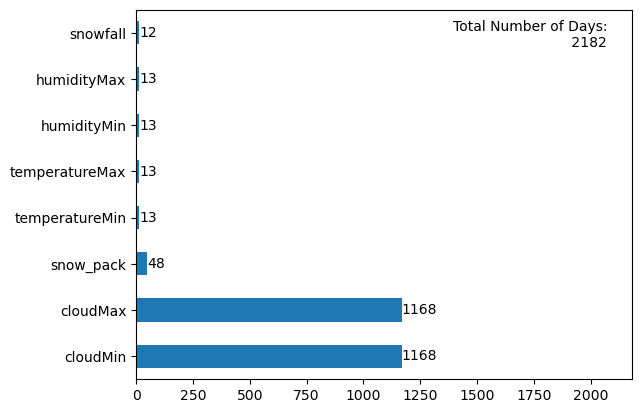

In [22]:
solar_missing = (
    complete_solar
    # Converting values in columns to True is missing, False if not missing
    .isnull()
    # Calculating the proportion of values missing
    .sum()
    # Sorting by missigness (0) then column name ('index')
    .reset_index()
    .sort_values([0, 'index'], ascending = False)
    # Removing the rows with no missing values
    [lambda series: series[0] > 0]
    # Moving the column names back as an index
    .set_index('index')
)

# Creating a horizontal bar chart
solar_missing_plot = solar_missing.plot(kind = 'barh', legend = False)

# Adding the counts next to the bars with missing values
for bar in solar_missing_plot.patches:
    # Getting the coordinates for the text
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    # Adding the text
    solar_missing_plot.text(width + 0.5, y, str(int(width)), va = 'center')

plt.ylabel('')
plt.xlim([0, len(complete_solar)])
plt.text(x = 0.95, y = 0.9, s = f'Total Number of Days:\n {len(complete_solar)}', transform = plt.gca().transAxes, ha = 'right');

`snowfall`, `humidity`s, `temperature`s, and `snow_pack` have a small number of days with missing records, while the `cloudMax` and `cloudMin` have a bit more than half the daily values missing. 

#### Missing: cloudMin and cloudMax

It would make sense that if one `cloud` value is missing (ie `cloudMin`), then the other value will be missing as well. Is that true?

In [24]:
days_with_cloud_missing = complete_solar[['cloudMax', 'cloudMin']].isnull().sum(axis = 1).value_counts()
days_with_cloud_missing

2    1168
0    1014
Name: count, dtype: int64

Since there are no days with only 1 missing value between the two cloud features, we can focus the examination on just one column. 

What are the earliest and latest dates with non-missing cloud values?

In [26]:
(
    complete_solar[['date', 'cloudMin']]
    .query('cloudMin.notnull()')
    .query('date == date.min() | date == date.max()')    
)

,date,cloudMin
1168,2020-10-21,1802.707
2181,2023-07-31,2040.118


It looks like the weather station didn't start recording cloudiness until October, 2020 with no missing values up to the final day (July 31st, 2023).

If we want to use the cloud cover features, we need to limit the data to after October 21st, 2020.

#### Missing: Snow features

Two other columns missing values involve snow. While Vermont can still be on the cooler side during late spring - early fall, snow fall is unlikely between end of May - early September. If the missing values are during that timeframe, we can replace them with 0s.

In [28]:
## Snow fall
# Replacing snowfall NaN with 0 if between May 15th and September 15th
snow_miss_may_sept = (complete_solar['snowfall'].isnull() &                     # Snowfall missing
                     (complete_solar['date'].dt.strftime('%m-%d') >='05-15') &  # After May 15th
                     (complete_solar['date'].dt.strftime('%m-%d') <='09-15'))   # Before Sept 15th

complete_solar.loc[snow_miss_may_sept, 'snowfall'] = 0

In [29]:
## Snow pack
# Replacing snow_pack NaN with 0 if between May 15th and September 15th
snow_miss_may_sept = (complete_solar['snow_pack'].isnull() &                    # Snowfall missing
                     (complete_solar['date'].dt.strftime('%m-%d') >='05-15') &  # After May 15th
                     (complete_solar['date'].dt.strftime('%m-%d') <='09-15'))   # Before Sept 15th

complete_solar.loc[snow_miss_may_sept, 'snow_pack'] = 0

In [30]:
complete_solar[['snowfall', 'snow_pack']].isnull().sum()

snowfall      1
snow_pack    16
dtype: int64

#### Mean Imputation

For the remaining missing values for the features other than `cloud` by finding the average of the three days before and three days after.

In [32]:
missing_features = ['snow_pack', 'temperatureMin', 'temperatureMax', 'humidityMin', 'humidityMax', 'snowfall']

for feature in missing_features:
    # Getting the indices of the rows with missing values for the feature
    miss_index = complete_solar[complete_solar[feature].isnull()].index

    # Looping through the indices 
    for i in miss_index:
        # Finding the date of 3 days earlier
        three_days_prior = complete_solar.loc[i, 'date'] - pd.Timedelta(days = 3)

        # Finding the date of 3 days later
        three_days_later = complete_solar.loc[i, 'date'] + pd.Timedelta(days = 3)

        # Picking the days between the above dates
        week_label = (complete_solar['date'] >= three_days_prior) & (complete_solar['date'] <= three_days_later)

        # Replacing the missing value with the mean of the week
        complete_solar.loc[i, feature] = complete_solar.loc[week_label, feature].mean()
       
# Checking if there are any missing values
complete_solar.isnull().sum()

date                 0
power                0
temperatureMax       0
temperatureMin       0
rainTotal            0
rainPercent          0
barometerMax         0
barometerMin         0
cloudMax          1168
cloudMin          1168
humidityMax          0
humidityMin          0
sunrise              0
sunset               0
elevation            0
azimuth              0
day_time             0
precip               0
snowfall             0
snow_pack            0
cloudy               0
snow_ground          0
day_year             0
month                0
month_label          0
year                 0
dtype: int64

## Exploratory Data Analysis

### Solar power

We'll start by examining the main variable of interest: solar power generation.

#### Histogram

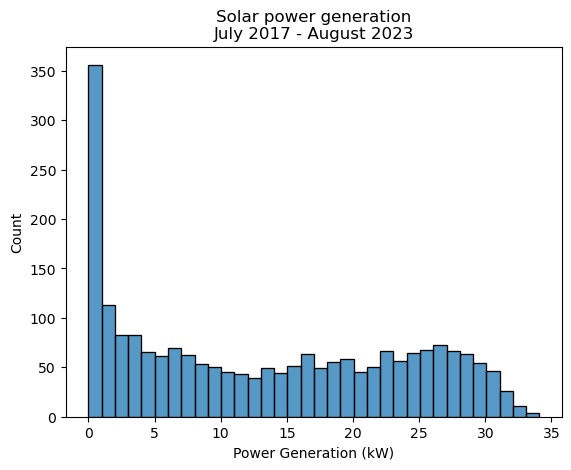

In [35]:
sns.histplot(
    data = complete_solar,
    x = complete_solar['power'],
    binwidth = 1
)

plt.title('Solar power generation\nJuly 2017 - August 2023')
plt.xlabel('Power Generation (kW)');

The bin for $[0, 1)$ is about 2.5 times taller than the next largest bin, indicating that there are many days where the panels generated little to no power. Let's look at what those days have in common.

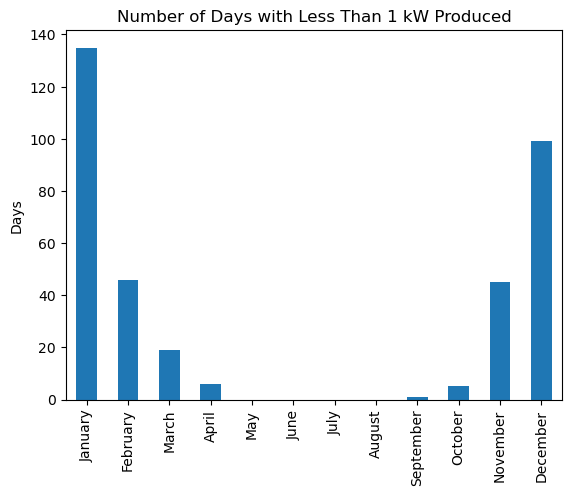

In [37]:
# Month abbreviation order
month_abb_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


(complete_solar
 .query('power < 1') # Days with no power generation
 # Counting how many times each month occurs
 ['month_label']
 .value_counts()
 # Sorting by index
 .sort_index()
 .plot(kind = 'bar')
)

plt.ylabel('Days')
plt.xlabel('')
plt.title('Number of Days with Less Than 1 kW Produced');

The colder months (November - March) are more likely to have days without any power generations. These are also the most likely months to have snow cover, which would block the panels from receiving the UV rays they need to generate electricity. 

Let's compare `power` by `month` and `snow_ground`:

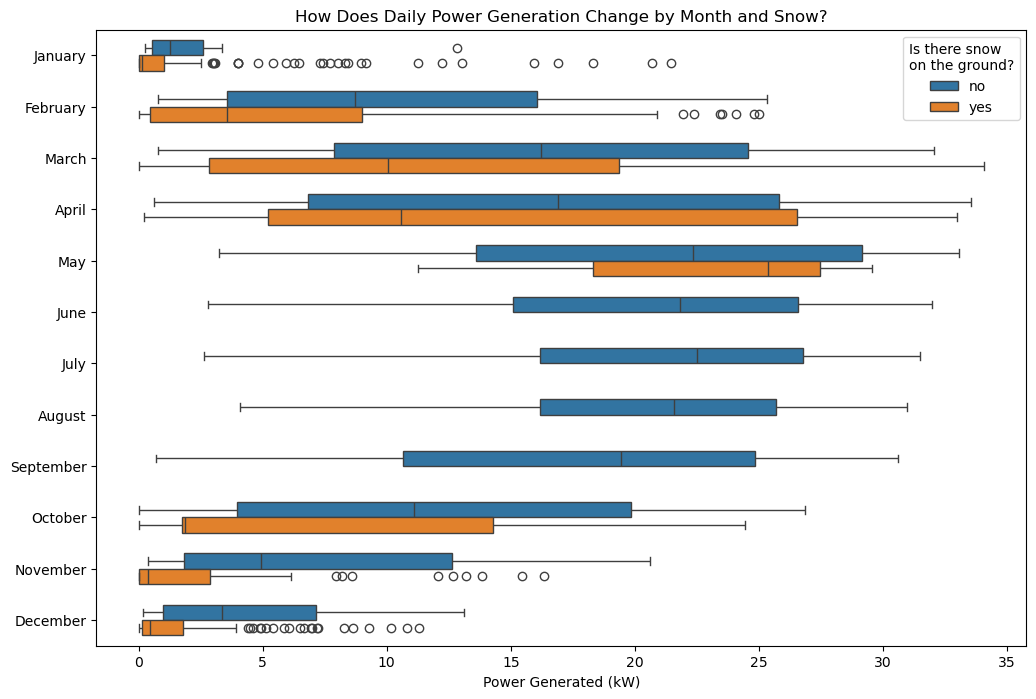

In [39]:
plt.figure(figsize = (12, 8))
sns.boxplot(
    data = complete_solar,
    x = 'power',
    y = 'month_label',
    hue = 'snow_ground',
    dodge = True,
    width = 0.6
)

plt.title('How Does Daily Power Generation Change by Month and Snow?')
plt.ylabel('')
plt.legend(title = 'Is there snow\non the ground?')
plt.xlabel('Power Generated (kW)');

In [40]:
(
    complete_solar
    .query('snow_ground == "yes"')
    ['month_label']
    .value_counts()
    .sort_index()
)

month_label
January      175
February     145
March        136
April         31
May            3
June           0
July           0
August         0
September      0
October        5
November      68
December     135
Name: count, dtype: int64

In [41]:
(
    complete_solar
    .query('(snow_ground == "yes") & (month_label == "August")')
)

,date,power,temperatureMax,temperatureMin,rainTotal,rainPercent,barometerMax,barometerMin,cloudMax,cloudMin,...,day_time,precip,snowfall,snow_pack,cloudy,snow_ground,day_year,month,month_label,year
